# Exploratory Data Analysis (Time & Gambles)

We are going to be looking for patterns in players who only played in the month of June. This is with the purpose to distinguish players between short and long positions, and the reasons why they hold this positions. 

In [1]:
# import all necesary libraries for the project
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import plotting_fn as pf
warnings.filterwarnings('ignore')

In [2]:
# Define working directory
path = "/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/1_Generic"
os.chdir(path)

# Filter Columns
filter = ['playerkey', 'playercashableamt', 'wageredamt', 'maxbet', 'grosswin',
       'currencyinamt', 'assetnumber', 'theoreticalpaybackpercent', 
       'age', 'rank', 'gender', 'date', 'start_time', 'end_time', 'duration',
       'slotdenomination']
# Import data
dtf = pd.read_parquet('month_7_year_2015.parquet', columns=filter)

# Check data
dtf.columns

# Select only the rows where duration is greater than or equal to zero
dtf = dtf[dtf['duration'] >= pd.Timedelta(0)]

In [3]:
# Sort data by start_time and playerkey
dtf = dtf.sort_values(by=['playerkey', 'date', 'start_time'])

## Calculate Foundamental Variables

The following variables were calculated using existing data:
* _player_loss_: how much money each player has lost in each gamble.
* _player_wins_: equals the amount of money they bet plus how much they won.
* _percent_return_: the return in player's bets for each gamble played. 

$$\text{percent return} = (\frac{df[wins] - df[wageredamt]}{df[wageredamt]})*100$$

* _playercashableamt_pct_change_: calculates the rate of change of player's outstanding gambling amount. 

$$\text{playercashableamt \% change} = (\frac{df[playercashableamt_{t+1}] - df[playercashableamt_{t}]}{df[playercashableamt_{t}]})*100$$

In [4]:
# Crate a new colum that is the inverse of casino_grosswin, named "player_loss"
dtf['ops'] = dtf['grosswin']*-1

# Create a new column that is the inverse of casino_grosswin, named "player_loss" that includes all negative values of 'ops'
dtf['player_loss'] = np.where(dtf['ops'] < 0, dtf['ops'], 0)

# Create a new column that is the inverse of casino_grosswin, named "player_wins" that includes all positive values of 'ops'
dtf['player_wins'] = np.where(dtf['ops'] > 0, dtf['ops'], 0)

# Create total_amt_won column
dtf['total_amt_won'] = dtf["wageredamt"]+dtf["ops"]

# Create colum profit
dtf['profit'] = dtf['total_amt_won'] - dtf['wageredamt']

# # Calculate percentage return for each gamble and add it as a new column
dtf["percent_return"] = ((dtf["wageredamt"]+dtf["ops"]) - dtf["wageredamt"]) / dtf["wageredamt"] * 100

# # Create a time series variable for each player that starts at 1 and increases by 1 for each row
draw_condition = dtf['grosswin'] == 0

for i, row in dtf.iterrows():
    if draw_condition[i]:
        dtf.loc[i, 'profit'] = 0

# Drop 'ops' column
dtf = dtf.drop(columns=['ops'])

# Create a time series variable for each player that starts at 1 and increases by 1 for each row
dtf["gambles"] = dtf.groupby("playerkey").cumcount() + 1

### Calulates Number of Visits

In [5]:
# Group the DataFrame by playerkey
groups = dtf.groupby('playerkey')

# Initialize the visit column to 1 for the first visit of each player
dtf['visit'] = groups['date'].transform(lambda x: (x.diff().dt.days >= 1).cumsum() + 1)

# Reset the visit count for each new player
dtf['visit'] = dtf.groupby('playerkey')['visit'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate Sessions based on Time

If there is a pause of 30 minutes or more between gambles it is considered the end of a session, and the start of a new one.

In [6]:
# Convert the start_time column to datetime
dtf["start_time"] = pd.to_datetime(dtf["start_time"])

# Sort data by start_time and playerkey
dtf = dtf.sort_values(by=['playerkey', 'date', 'start_time'])

# Compute the time difference between consecutive gambles for each player
dtf['time_diff'] = dtf.groupby('playerkey')['start_time'].diff()

# Initialize the session_time column to 1 for the first gamble of each player
dtf['session_time'] = dtf.groupby('playerkey').ngroup() + 1

# Update the session_time column based on the time difference
dtf['session_time'] += (dtf['time_diff'] > pd.Timedelta(minutes=30)).cumsum()

# Reset the session_time count for each new visit
dtf['session_time'] = dtf.groupby(['playerkey', 'visit'])['session_time'].apply(lambda x: x - x.iloc[0] + 1)

# Remove the temporary time_diff column
dtf = dtf.drop('time_diff', axis=1)

### Drop Players who played simultaneously in two machines

In [7]:
# Simultaneous Play
df_sim = pf.simultaneous_play(40000, dtf, 'session_time')

# Remove repeated instances
df_sim_no_repeat_v = df_sim.drop_duplicates(subset=['session_time', 'playerkey'])

In [8]:
# Print unique number of players in dtf
print("Number of unique players in dtf: ", len(dtf['playerkey'].unique()))
# Prnt the number of players that played simultaneously
print("Number of players that played simultaneously: ", len(df_sim_no_repeat_v))

# Eliminate all the players that played simultaneously from the original dataset (dtf)
dtf = dtf[~dtf['playerkey'].isin(df_sim_no_repeat_v['playerkey'])]

# Print unique number of players in dtf
print("Number of unique players in dtf: ", len(dtf['playerkey'].unique()))

Number of unique players in dtf:  14472
Number of players that played simultaneously:  1054
Number of unique players in dtf:  13619


### Calculate Sessions based on Machine Change

Everytime a player switches machine a new sessions begins.

In [9]:
# Initialize the session_machine column to 1 for the first machine of each player
dtf['session_machine'] = (dtf.groupby("playerkey")["assetnumber"].diff() != 0).cumsum()

# Reset the session_machine count for each new visit
dtf['session_machine'] = dtf.groupby(['playerkey', 'visit'])['session_machine'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Visit

In [10]:
# Create a column named "gambles_visit" that is the number of gambles per visit
dtf["gambles_visit"] = dtf.groupby(["playerkey", "visit"])["gambles"].cumcount() + 1

# Reset the gambles_visit count for each new visit
dtf['gambles_visit'] = dtf.groupby(['playerkey', 'visit'])['gambles_visit'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Session Time

In [11]:
# Create a column named "gambles_session" that is the number of gambles per session
dtf["gambles_session"] = dtf.groupby(["playerkey", "session_time"])["gambles"].cumcount() + 1

# Reset the gambles_session count for each new session
dtf['gambles_session'] = dtf.groupby(['playerkey', 'session_time'])['gambles_session'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Session Machine

In [12]:
# Create a column named "gambles_machine" that is the number of gambles per session_machine
dtf["gambles_machine"] = dtf.groupby(["playerkey", "session_machine"])["gambles"].cumcount() + 1

# Reset the gambles_machine count for each new session_machine
dtf['gambles_machine'] = dtf.groupby(['playerkey', 'session_machine'])['gambles_machine'].apply(lambda x: x - x.iloc[0] + 1)

### Calculate the number of Machine Changes


In [13]:
# Create a column called change_machine that is 1 everytime a player changes assetnumber 0 otherwise, grouped by playerkey and session_time
dtf['machines_played'] = (dtf.groupby(['playerkey', 'session_time'])['assetnumber'].diff() != 0).astype(int)

# Percentiles

## Overall Gambles

In [14]:
# Calculate the number of gambles per each player, and store it in a list
gambles_per_player = []
for i in dtf["playerkey"].unique().tolist():
    gambles_per_player.append(dtf[dtf["playerkey"] == i]["gambles"].max())

every_bodyelse = np.percentile(gambles_per_player, 50)
print("Median of the number of gambles per player:", every_bodyelse)

top_10 = np.percentile(gambles_per_player, 90)
print("Top 10% of the number of gambles per player:", top_10)

top_5 = np.percentile(gambles_per_player, 95)
print("Top 5% of the number of gambles per player:", top_5)

top_1 = np.percentile(gambles_per_player, 99)
print("Top 1% of the number of gambles per player:", top_1)


Median of the number of gambles per player: 146.0
Top 10% of the number of gambles per player: 894.2000000000007
Top 5% of the number of gambles per player: 1434.0999999999985
Top 1% of the number of gambles per player: 3418.0999999999985


## Top players Only

In [15]:
# Let's create a list of players that are extreme gamblers
extreme_r = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() >= top_10].index.tolist()

# Let's create a dataframe that only includes the extreme gamblers
dtf_extreme = dtf[dtf["playerkey"].isin(extreme_r)]

# Calculate the number of gambles per each player, and store it in a list
gambles_per_top_player = []
for i in dtf_extreme["playerkey"].unique().tolist():
    gambles_per_top_player.append(dtf_extreme[dtf_extreme["playerkey"] == i]["gambles"].max())

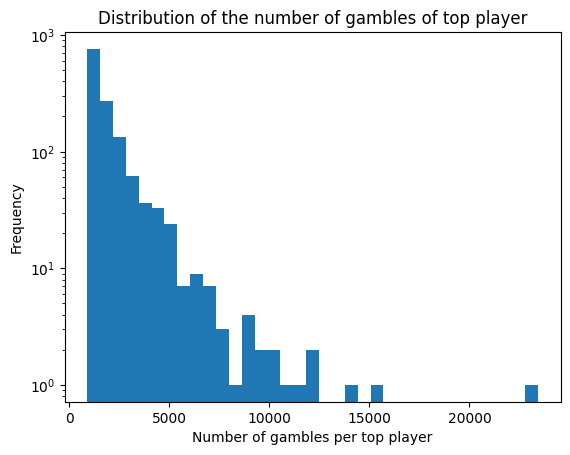

In [16]:
# Plot the distribution of the number of gambles per top player
plt.hist(gambles_per_top_player, bins=35, log=True)
plt.xlabel("Number of gambles per top player")
plt.ylabel("Frequency")
plt.title("Distribution of the number of gambles of top player")
plt.show()

## Everybody Else

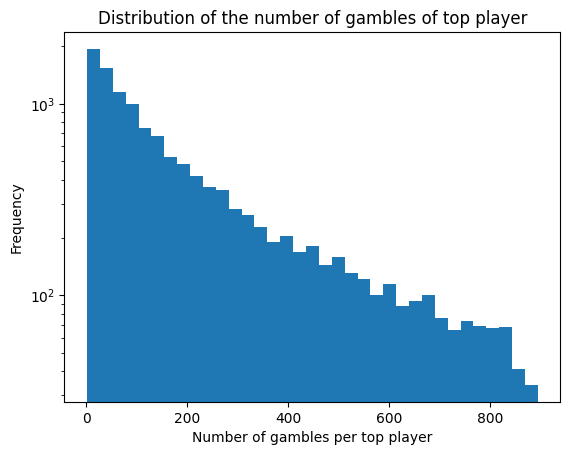

In [17]:
# Let's create a list of players that are extreme gamblers
low_r = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() < top_10].index.tolist()

# Let's create a dataframe that only includes the extreme gamblers
dtf_Ntop = dtf[dtf["playerkey"].isin(low_r)]
           
# Calculate the number of gambles per each playER and store it in a list

gambles_per_Ntop_player = []
for i in dtf_Ntop["playerkey"].unique().tolist():
    gambles_per_Ntop_player.append(dtf_Ntop[dtf_Ntop["playerkey"] == i]["gambles"].max())

# Plot the distribution of the number of gambles per top player
plt.hist(gambles_per_Ntop_player, bins=35, log=True)
plt.xlabel("Number of gambles per top player")
plt.ylabel("Frequency")
plt.title("Distribution of the number of gambles of top player")
plt.show()

# Create Dataframes from total number of Gambles

In [18]:
# Let's create two separarte dataframes for the top 20% and bottom 20% of players by creating a list of player for each percentile
top10 = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() >= top_10].index.tolist()
Ntop = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() < top_10].index.tolist()

# How many players are in extreme_r?
print("# of playes in Non-Top:", len(Ntop))

# How many players are in low_r?
print("# of players in Top 10:", len(top10))

# # Create a dataframe for the top10 players
dtf_top10 = dtf[dtf["playerkey"].isin(top10)]
dtf_top10['clasification'] = "top_10"

# # Create a dataframe for the top1 players
dtf_Ntop = dtf[dtf["playerkey"].isin(Ntop)]
dtf_Ntop['clasification'] = "Ntop"

# # Concatenate the four dataframes into one
dtf_top = pd.concat([dtf_Ntop, dtf_top10])

# of playes in Non-Top: 12257
# of players in Top 10: 1362


# Save Dataframes

In [19]:
# Define saving path
path = "/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/3_July"
os.chdir(path)

# General Dataframe to parquet
dtf_top.to_parquet("top_vs_ntop_players.parquet", engine="pyarrow")
